In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.metrics import  accuracy_score , ConfusionMatrixDisplay , classification_report , roc_auc_score
from sklearn.preprocessing import StandardScaler 


import warnings
warnings.filterwarnings("ignore")

In [2]:
drug_data = pd.read_csv("drug200.csv")

In [3]:
drug_data.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [4]:
drug_data.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [5]:
drug_data.duplicated().sum()

np.int64(0)

In [6]:
drug_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


* **Unique Values**

In [7]:
pd.concat(
    {
        "Columns" : drug_data.apply(pd.unique) ,
        "Values" : drug_data.nunique() , 
    } , axis=1
)

,Columns,Values
Age,"[23, 47, 28, 61, 22, 49, 41, 60, 43, 34, 74, 5...",57
Sex,"[F, M]",2
BP,"[HIGH, LOW, NORMAL]",3
Cholesterol,"[HIGH, NORMAL]",2
Na_to_K,"[25.355, 13.093, 10.114, 7.798, 18.043, 8.607,...",198
Drug,"[drugY, drugC, drugX, drugA, drugB]",5


In [8]:
drug_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,200.0,44.315000,16.544315,15.000,31.0000,45.0000,58.00,74.000
Na_to_K,200.0,16.084485,7.223956,6.269,10.4455,13.9365,19.38,38.247


* **Drug Column Values Update**

In [9]:
drug_data["Drug"] = drug_data["Drug"].replace(
    {
        "drugY" : "Y" ,
        "drugX" : "X" , 
        "drugA" : "A" , 
        "drugB" : "B" , 
        "drugC" : "C" , 
        
    }
)

In [10]:
drug_data.value_counts("Drug")

Drug
Y    91
X    54
A    23
B    16
C    16
Name: count, dtype: int64

In [11]:
fig = px.pie(
    drug_data , 
    names= "Drug" , 
    color_discrete_sequence= px.colors.qualitative.Set1 , 
    title= "Drug"
)

fig.update_traces(textinfo="label + percent")


fig.update_layout(
    width = 1100 , 
    height = 800
)

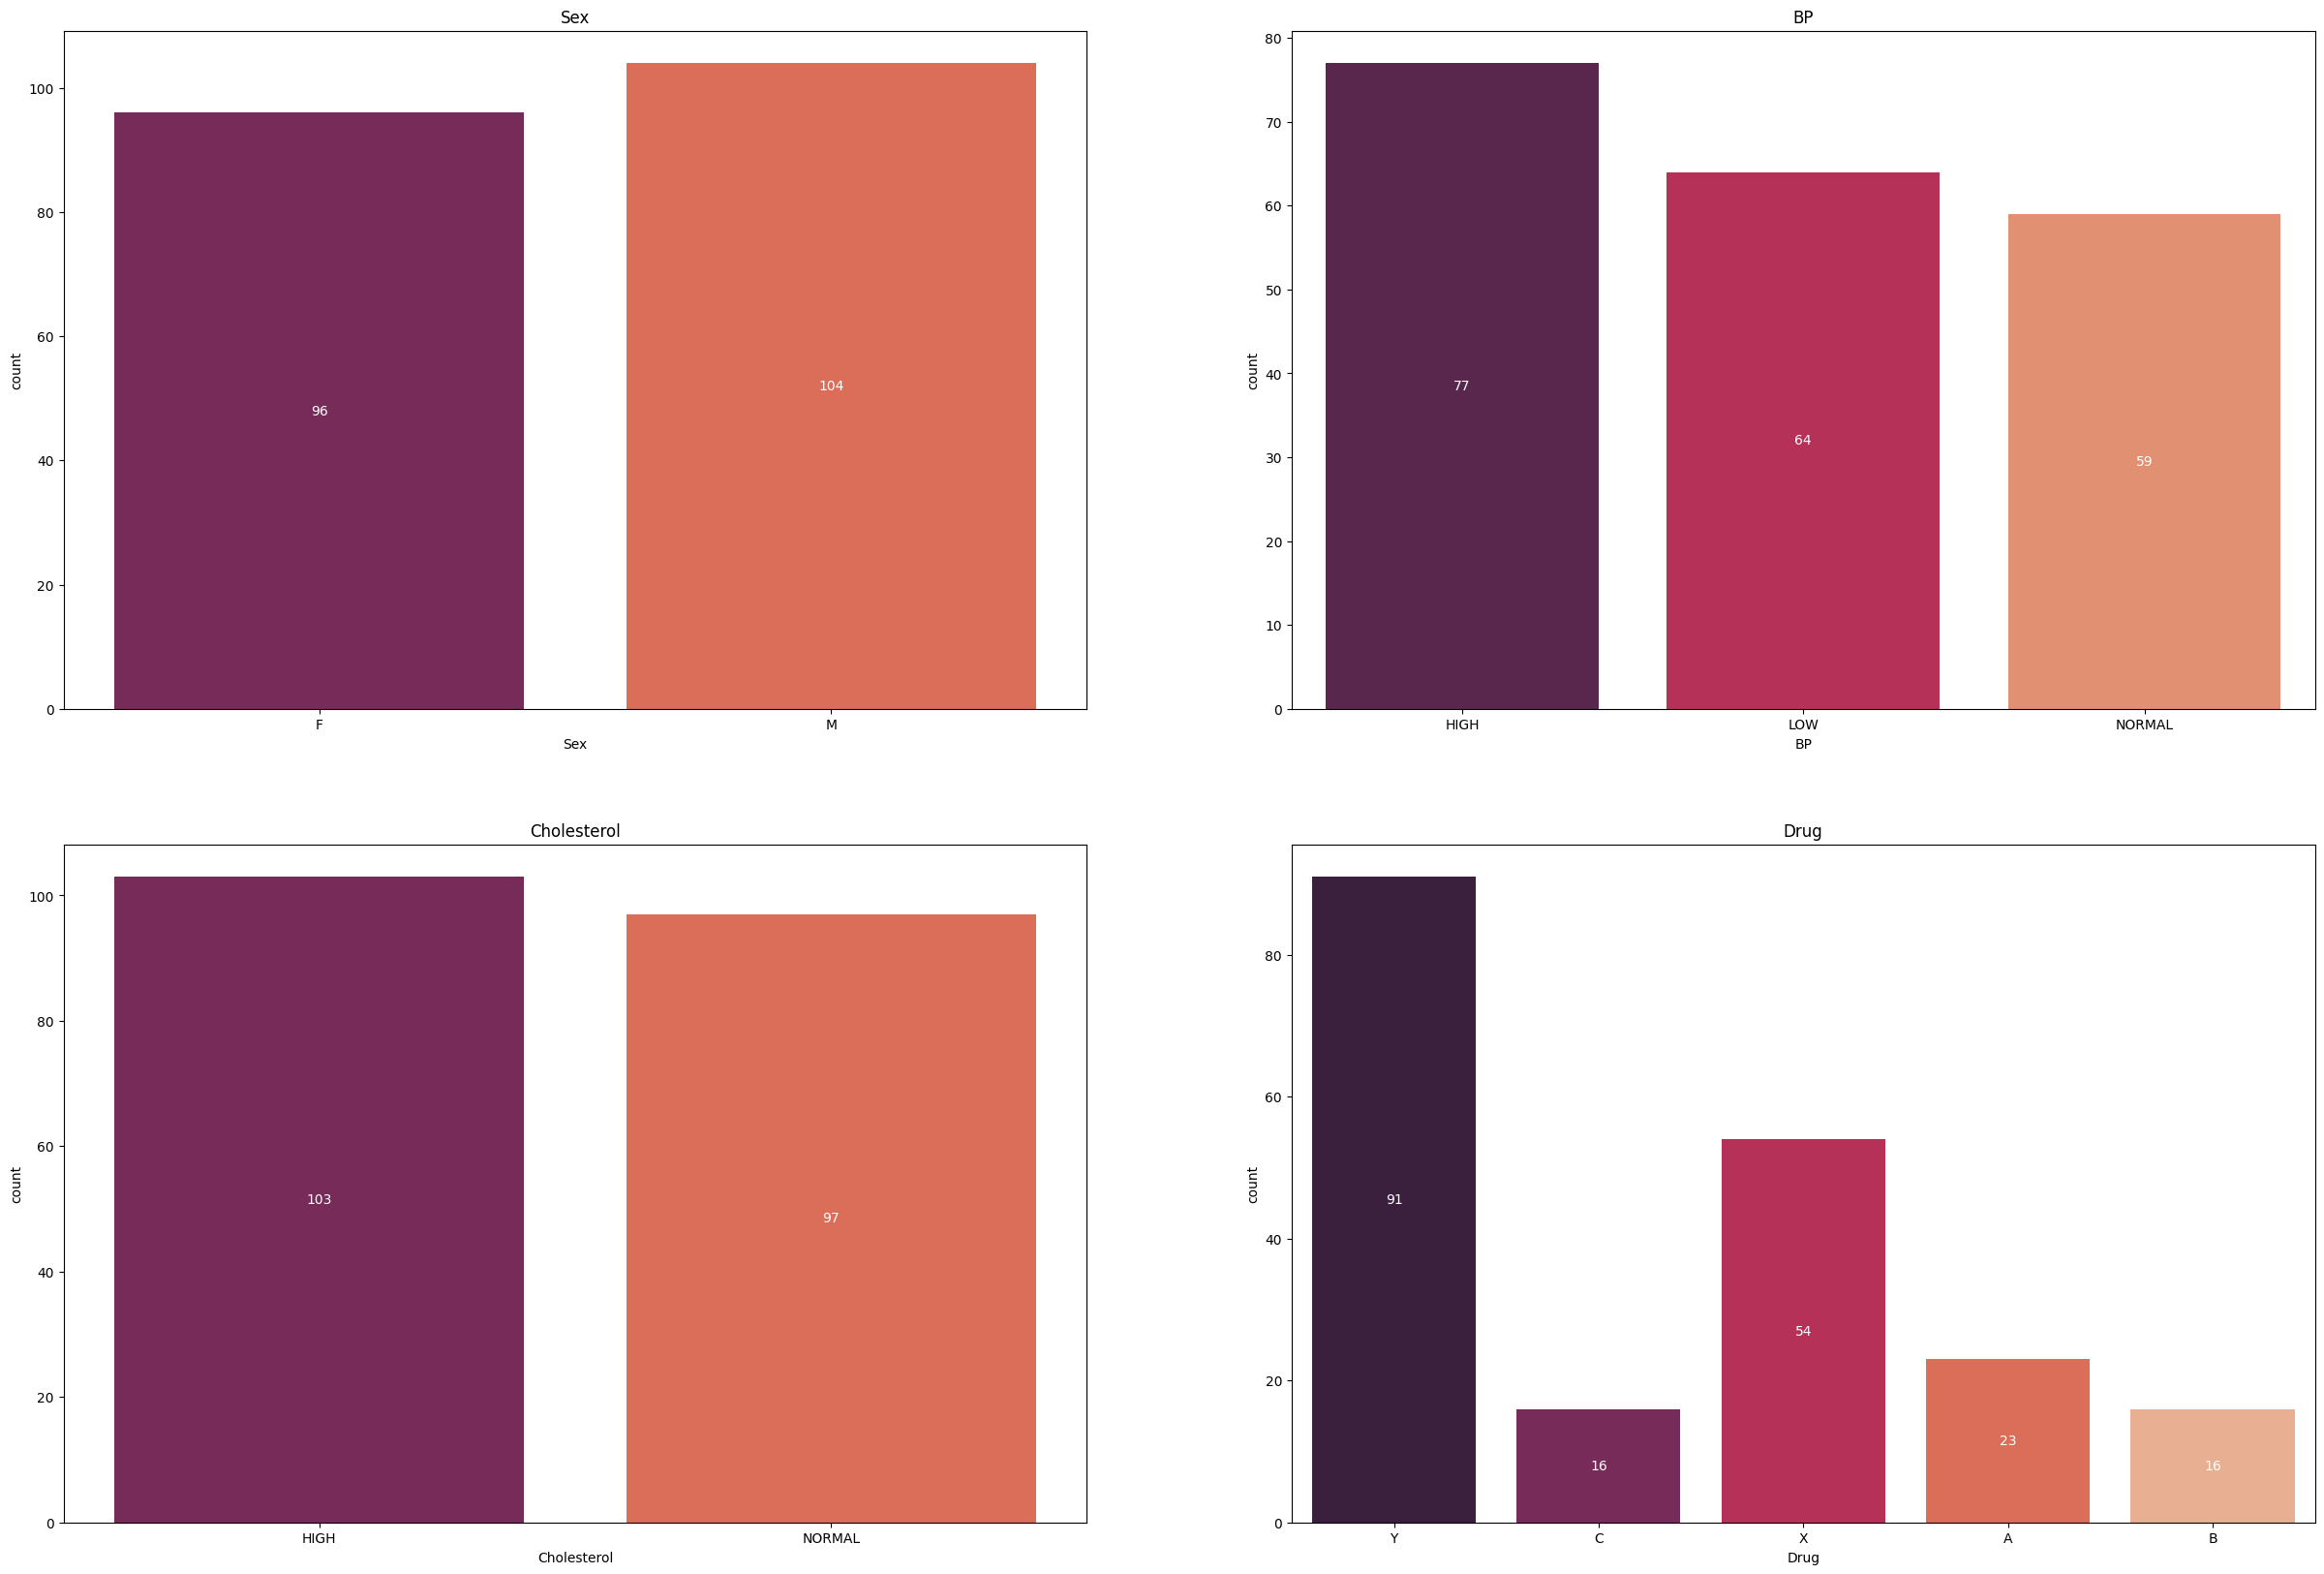

In [12]:
def count_plot_function(data):
    plt.figure(figsize=(30,20))
    
    for i , col in enumerate(drug_data.select_dtypes("object").columns):
        plt.subplot(2,2,i+1)


        ax = sns.countplot(x = col , palette="rocket" , data=data)

        for count in ax.containers:
            ax.bar_label(count  , label_type="center" , color = "white")

        plt.title(f"{col}")

count_plot_function(drug_data)        




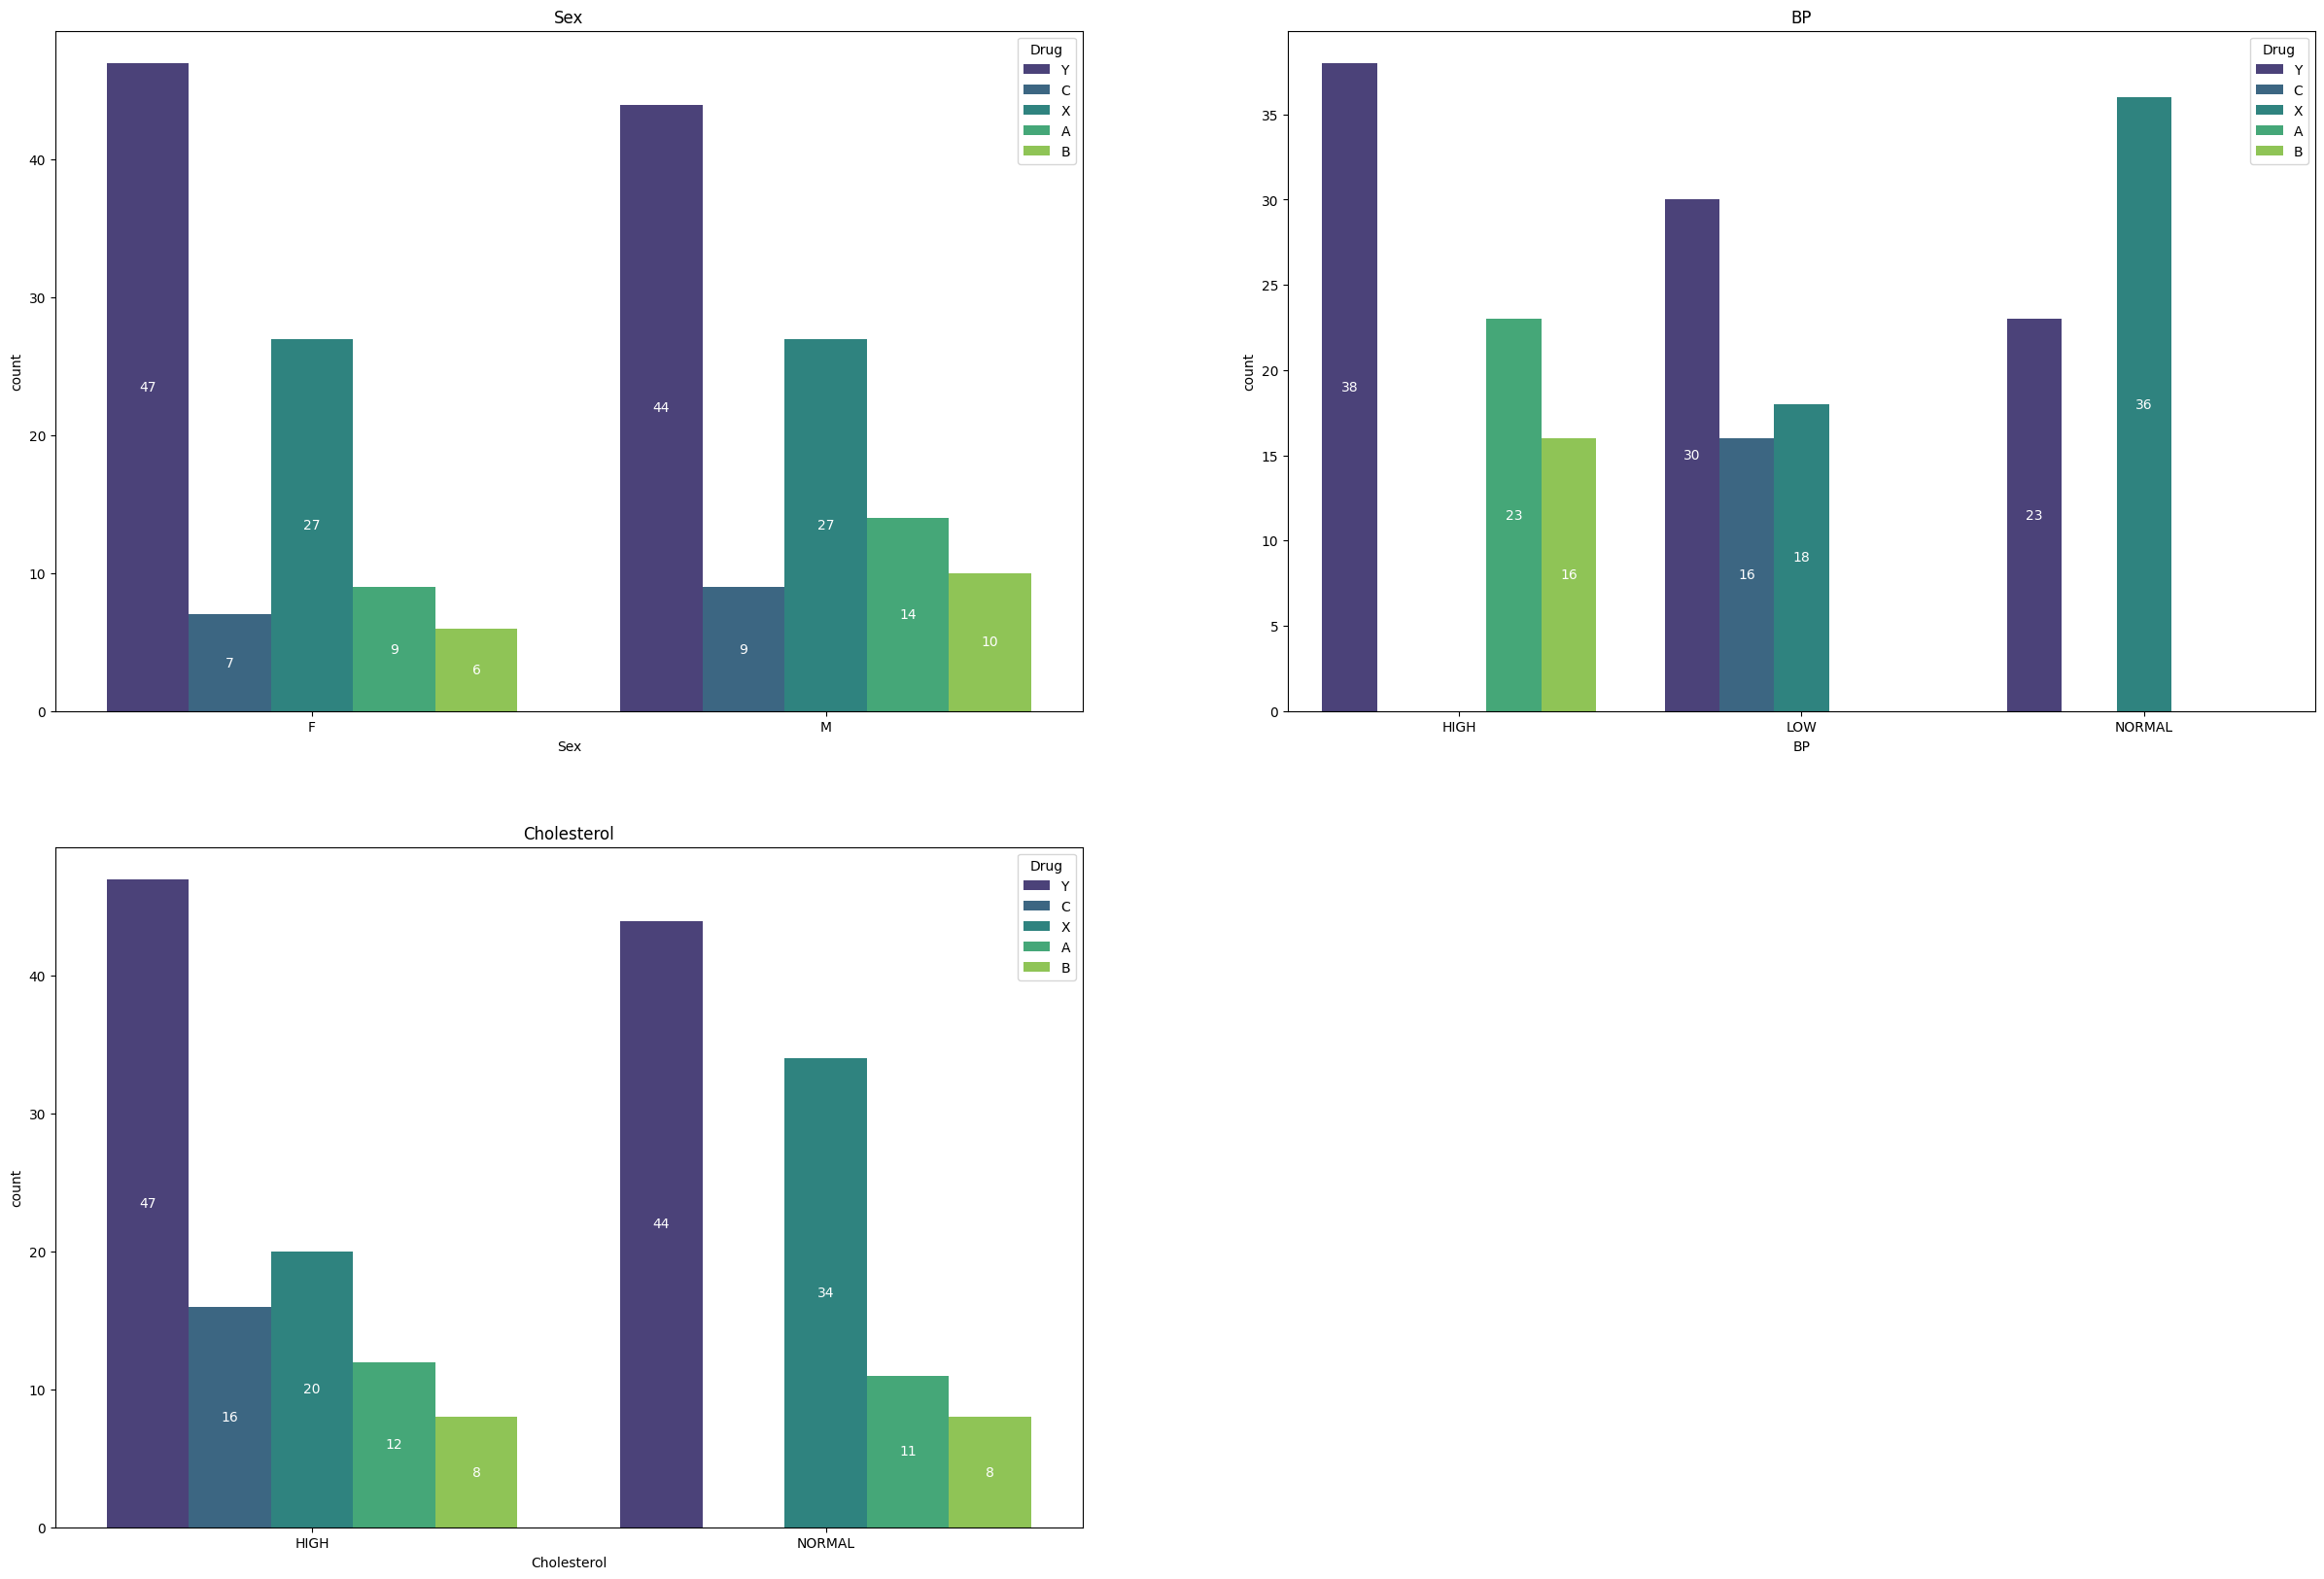

In [13]:
hue_col = drug_data[["Sex" , "BP" , "Cholesterol"]]

def count_plot_function(data):
    plt.figure(figsize=(30,20))
    
    for i , col in enumerate(hue_col.columns):
        plt.subplot(2,2,i+1)


        ax = sns.countplot(x = col , palette="viridis" ,hue="Drug" , data=data)

        for count in ax.containers:
            ax.bar_label(count  , label_type="center" , color = "white")

        plt.title(f"{col}")

count_plot_function(drug_data)    

<Axes: title={'center': 'Na_to_K & Drug Scatter'}, xlabel='Na_to_K', ylabel='Drug'>

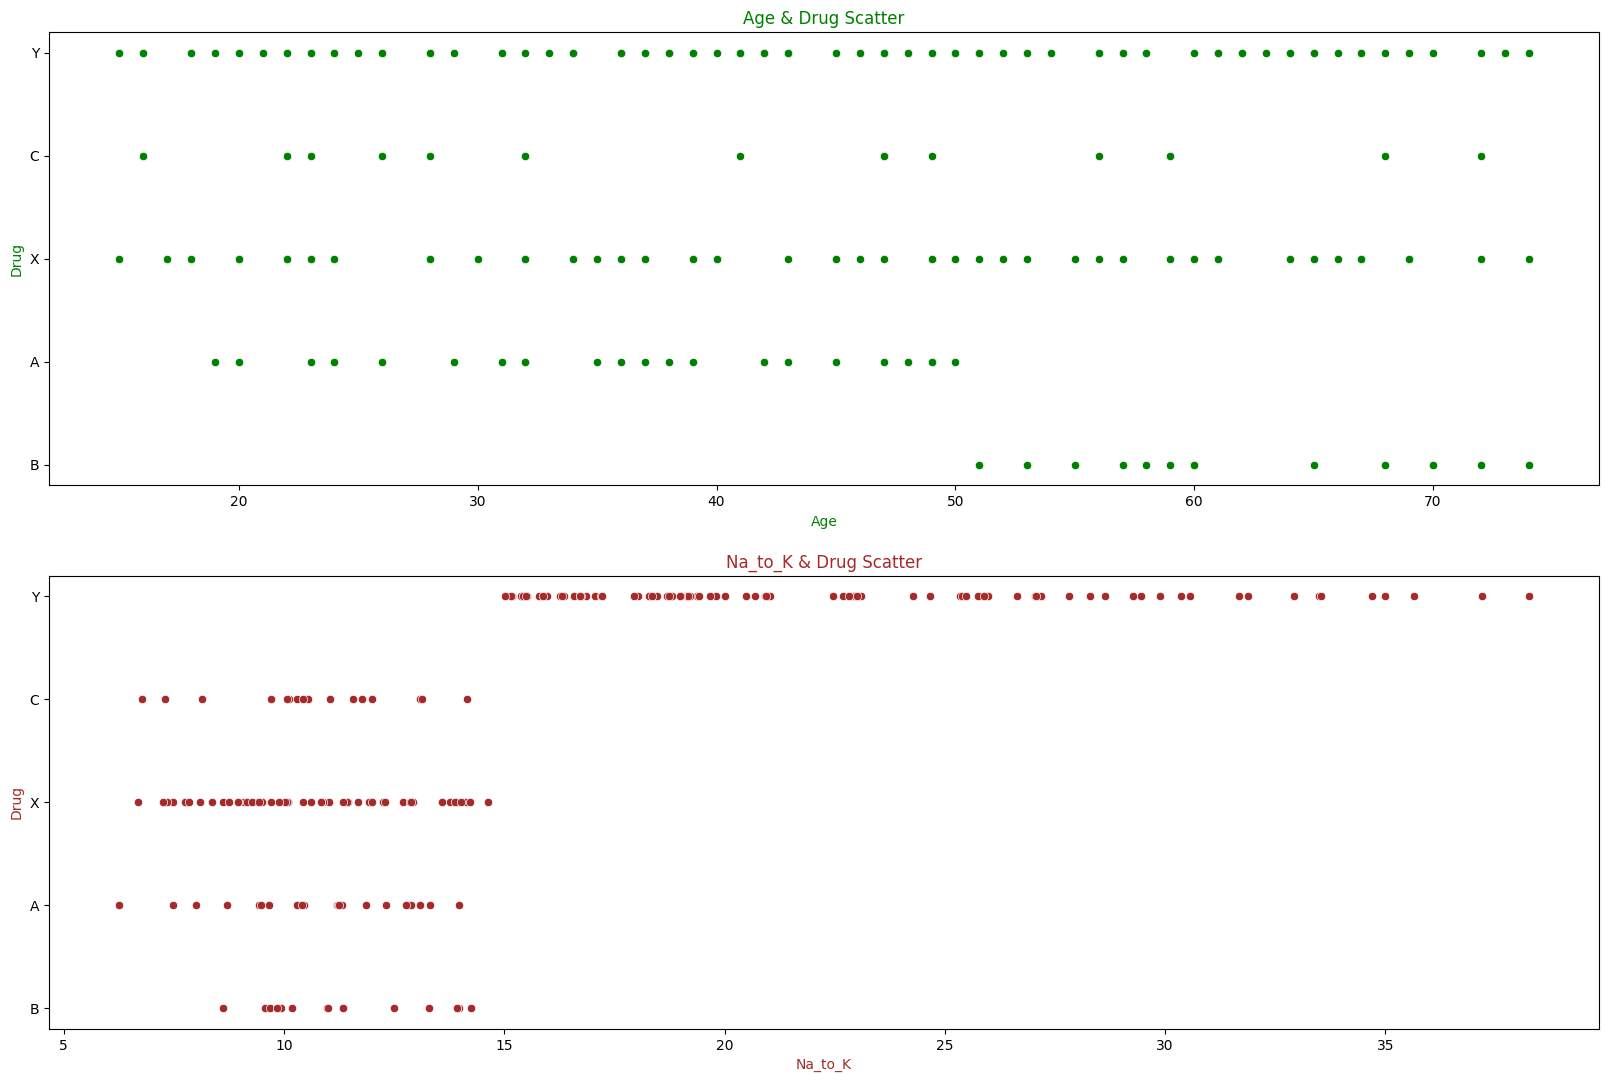

In [14]:
plt.figure(figsize=(20 , 20))

plt.subplot(3,1,1)
plt.title("Age & Drug Scatter" , color = "green")
plt.xlabel("Age" , color = "green")
plt.ylabel("Drug" , color = "green")
sns.scatterplot(data=drug_data , x="Age" , y = "Drug" , color="green")

plt.subplot(3,1,2)
plt.title("Na_to_K & Drug Scatter" , color = "brown")
plt.xlabel("Na_to_K" , color = "brown")
plt.ylabel("Drug" , color = "brown")
sns.scatterplot(data=drug_data , x="Na_to_K", y="Drug" , color="brown")


<Axes: xlabel='Na_to_K', ylabel='Age'>

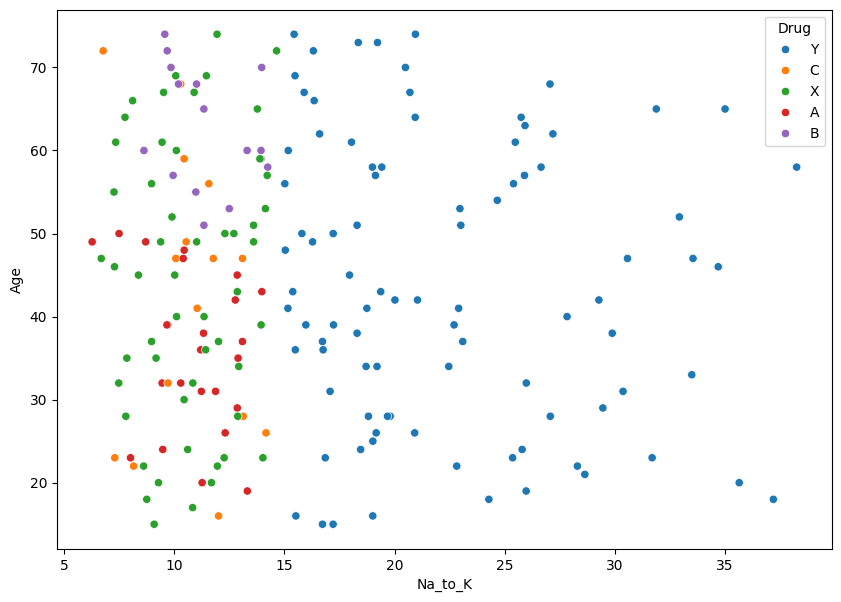

In [15]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=drug_data , x="Na_to_K", y="Age" , hue="Drug" , color="brown")

In [16]:
drug_data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,Y
1,47,M,LOW,HIGH,13.093,C
2,47,M,LOW,HIGH,10.114,C
3,28,F,NORMAL,HIGH,7.798,X
4,61,F,LOW,HIGH,18.043,Y
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,C
196,16,M,LOW,HIGH,12.006,C
197,52,M,NORMAL,HIGH,9.894,X
198,23,M,NORMAL,NORMAL,14.020,X


* **Encoding**

In [17]:
from sklearn.preprocessing import LabelEncoder

label_encoding = {}

for i in drug_data.select_dtypes("object"):
    label = LabelEncoder()
    drug_data[i] = label.fit_transform(drug_data[i])

    label_encoding[i] = label

In [18]:
for column , values in label_encoding.items():
    print(f"-------- {column} ---------")
    
    for i , category in enumerate(values.classes_):
        print(f"{category} : {i}")


-------- Sex ---------
F : 0
M : 1
-------- BP ---------
HIGH : 0
LOW : 1
NORMAL : 2
-------- Cholesterol ---------
HIGH : 0
NORMAL : 1
-------- Drug ---------
A : 0
B : 1
C : 2
X : 3
Y : 4


* **Pairplot**

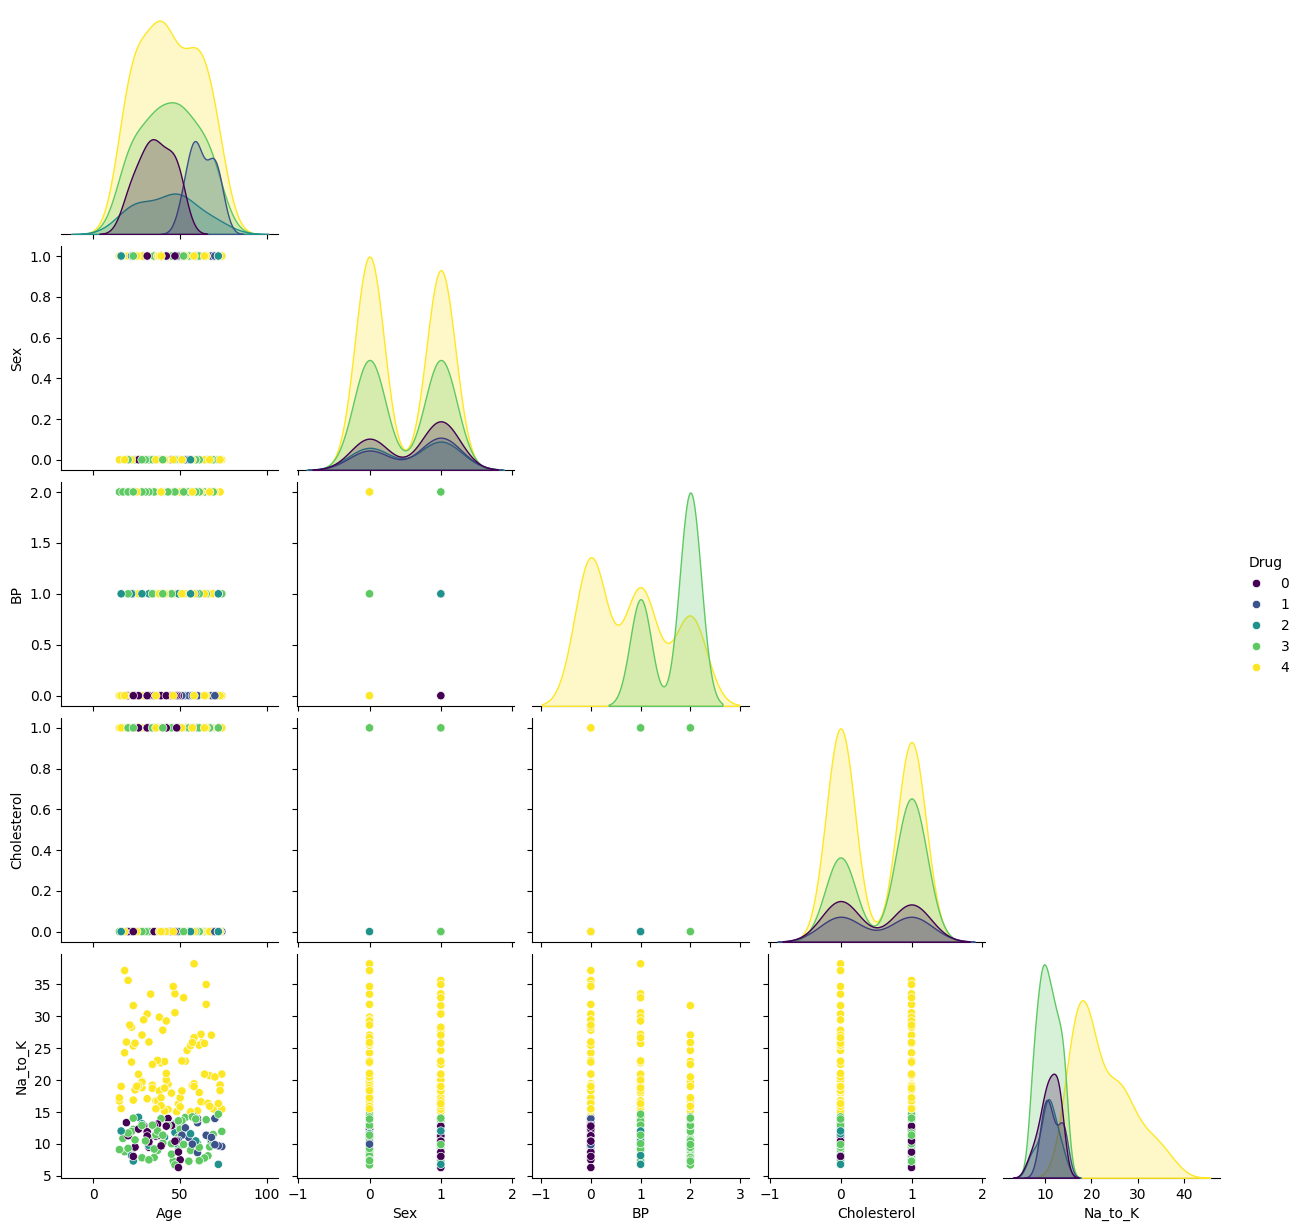

In [19]:
sns.pairplot(data=drug_data , hue="Drug" , corner=True , palette="viridis")

* **Heatmap**

<Axes: >

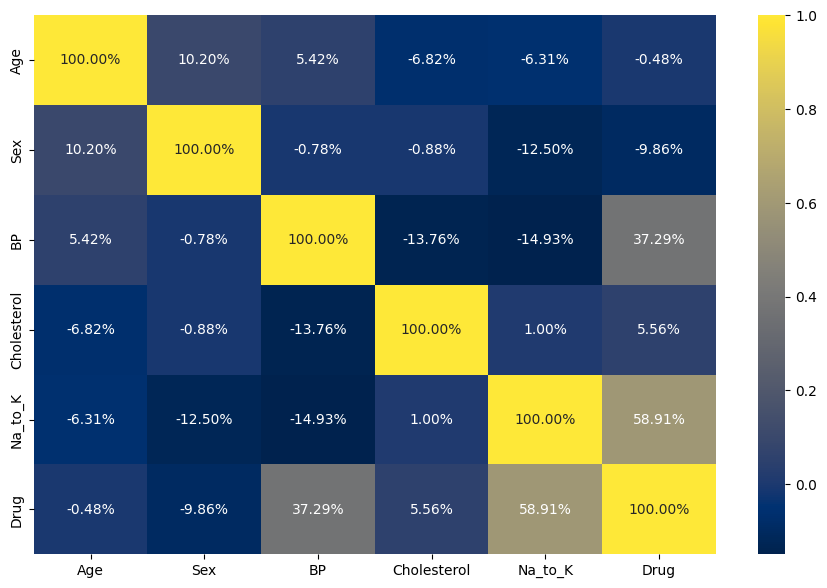

In [20]:
plt.figure(figsize=(11,7))
sns.heatmap(drug_data.corr() , annot=True , cmap="cividis" , fmt=".2%")

In [21]:
drug_data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,4
1,47,1,1,0,13.093,2
2,47,1,1,0,10.114,2
3,28,0,2,0,7.798,3
4,61,0,1,0,18.043,4
...,...,...,...,...,...,...
195,56,0,1,0,11.567,2
196,16,1,1,0,12.006,2
197,52,1,2,0,9.894,3
198,23,1,2,1,14.020,3


* **Train Test Split**

In [22]:
X = drug_data.drop("Drug" , axis=1)
y = drug_data["Drug"]

In [23]:
X_train , X_test , y_train , y_test = train_test_split(X , y,
                                                        random_state=4 ,
                                                          test_size=.2 , 
                                                          stratify=drug_data["Drug"])

In [24]:
X_train.head()

,Age,Sex,BP,Cholesterol,Na_to_K
22,47,1,1,1,30.568
53,24,0,0,1,18.457
11,34,0,0,1,19.199
116,67,1,2,1,9.514
158,59,0,1,0,10.444


* **Scaling**

In [25]:
scaler = StandardScaler()

X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

# Convert to Dataframe 

X_train = pd.DataFrame(X_train_scaler , columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaler , columns=X_test.columns)

In [26]:
X_train.head()

,Age,Sex,BP,Cholesterol,Na_to_K
0,0.174953,1.025320,0.128615,1.025320,1.994205
1,-1.221638,-0.975305,-1.081875,1.025320,0.320359
2,-0.614424,-0.975305,-1.081875,1.025320,0.422910
3,1.389380,1.025320,1.339104,1.025320,-0.915642
4,0.903610,-0.975305,0.128615,-0.975305,-0.787107


* **Model**

In [27]:
tree = DecisionTreeClassifier()

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
param_grid = {
    "max_depth" : [2,3,4,5] , 
    "criterion" : ["gini" , "entropy"] ,
    "max_leaf_nodes" : [5,6,7,8,9,10] , 
    "max_features" : [1,3,5,7,9]
 }

In [30]:
grid_model = GridSearchCV(
    estimator= tree , 
    param_grid= param_grid , 
    cv=5 , 
    verbose= 1 
)

In [31]:
grid_model.fit(X_train , y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5],
                         'max_features': [1, 3, 5, 7, 9],
                         'max_leaf_nodes': [5, 6, 7, 8, 9, 10]},
             verbose=1)

In [32]:
best_model = grid_model.best_estimator_
best_model

DecisionTreeClassifier(max_depth=4, max_features=5, max_leaf_nodes=6)

In [33]:
best_model.criterion

'gini'

In [34]:
tree = DecisionTreeClassifier(max_depth=4 , max_features=5 , max_leaf_nodes=6 , criterion="gini")

In [35]:
tree.fit(X_train , y_train)

DecisionTreeClassifier(max_depth=4, max_features=5, max_leaf_nodes=6)

In [36]:
y_pred = tree.predict(X_test)

* **Metrics**

In [37]:
print(accuracy_score(y_test , y_pred) * 100)

100.0


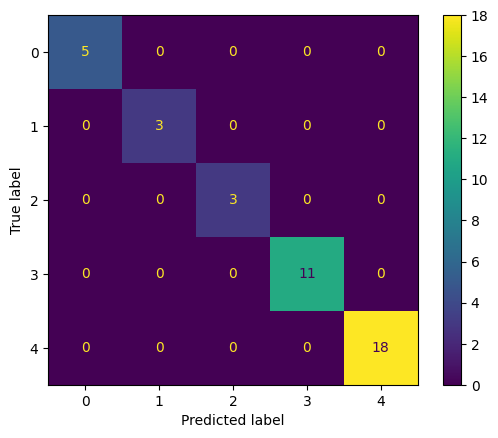

In [38]:
ConfusionMatrixDisplay.from_estimator(grid_model , X_test , y_test)

In [39]:
print(classification_report(y_test ,  y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        18

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



#### Overfitting 

In [40]:
from sklearn.preprocessing import label_binarize

y_pred = best_model.predict(X_test) 
y_proba = best_model.predict_proba(X_test)

y_test_bin = label_binarize(y_test , classes=best_model.classes_)

print("Roc-Auc-Score:" , roc_auc_score(y_test_bin , y_proba , average="macro" , multi_class="ovr")  )

Roc-Auc-Score: 1.0


In [41]:
# Test data 
y_pred_test = best_model.predict(X_test)
y_proba_test = best_model.predict_proba(X_test)
y_test_bin = label_binarize(y_test , classes=best_model.classes_)

# Train Data 
y_pred_train  = best_model.predict(X_train)
y_proba_train = best_model.predict_proba(X_train) 
y_train_bin = label_binarize(y_train , classes=best_model.classes_)

# Roc-auc 
roc_auc_train = roc_auc_score(y_train_bin , y_proba_train , average="macro" , multi_class="ovr" ) 
roc_auc_test = roc_auc_score(y_test_bin , y_proba_test , average="macro" , multi_class="ovr")

print("Train roc:" , roc_auc_train)
print("Test roc:" , roc_auc_test)

Train roc: 1.0
Test roc: 1.0


In [42]:
overfit_pred_train = best_model.predict(X_train)
overfit_pred_test = best_model.predict(X_test)

print(accuracy_score(y_test , overfit_pred_test) * 100)
print(accuracy_score(y_train , overfit_pred_train) * 100)


100.0
100.0


* **Smote Model**

In [43]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=4)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

grid_model.fit(X_train_res, y_train_res)



Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5],
                         'max_features': [1, 3, 5, 7, 9],
                         'max_leaf_nodes': [5, 6, 7, 8, 9, 10]},
             verbose=1)

In [44]:
y_pred_res = best_model.predict(X_train_res)
y_proba_res = best_model.predict_proba(X_train_res)

In [45]:
print("Train Accuracy:", accuracy_score(y_train_res, y_pred_res))

Train Accuracy: 1.0


In [46]:
print("Train ROC-AUC Score:",
       roc_auc_score(
           label_binarize
           (y_train_res, classes=grid_model.classes_) ,  y_proba_res, average="macro", multi_class="ovr")
           )


Train ROC-AUC Score: 1.0


In [47]:
best_model.feature_importances_

array([0.13600697, 0.        , 0.27532574, 0.11243243, 0.47623486])

* **Coefs**

In [48]:
Coef = pd.DataFrame(
    index = X.columns ,
    data = best_model.feature_importances_ ,
    columns = ["Feature Coef"]
)

Coef

,Feature Coef
Age,0.136007
Sex,0.000000
BP,0.275326
Cholesterol,0.112432
Na_to_K,0.476235


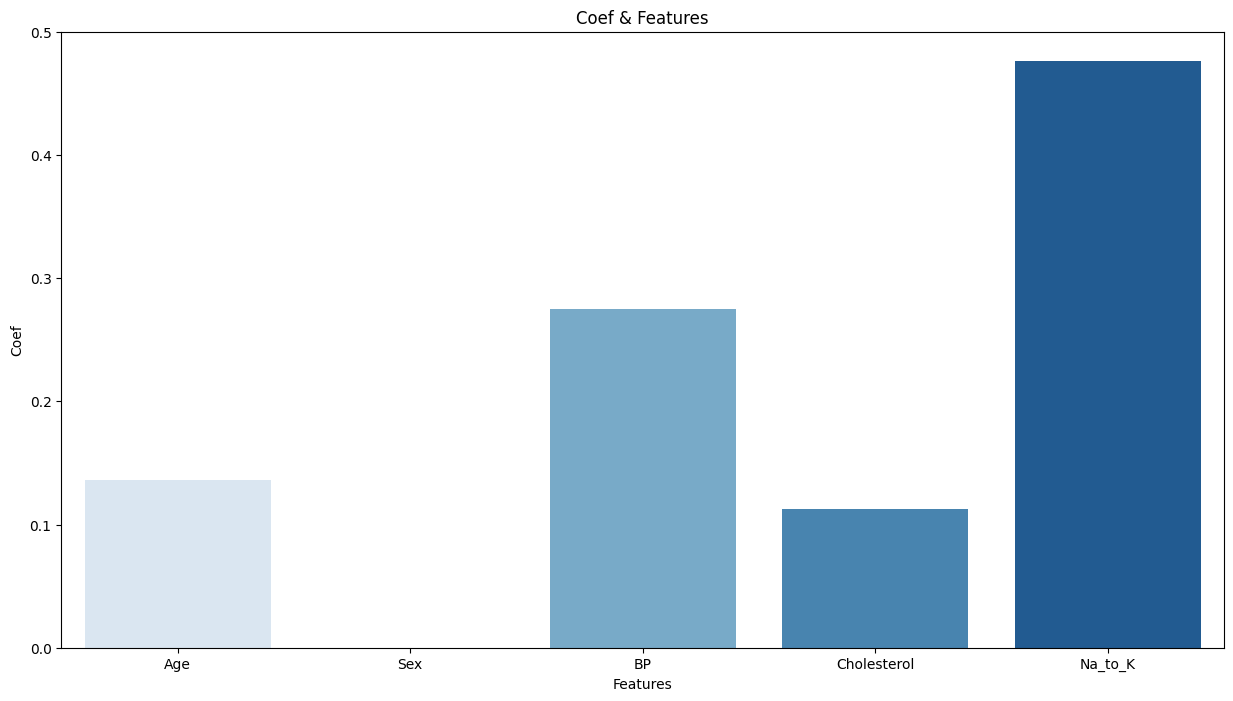

In [49]:
plt.figure(figsize=(15,8))

sns.barplot(x=Coef.index , y="Feature Coef" , data=Coef , palette="Blues")
plt.title("Coef & Features")
plt.xlabel("Features")
plt.ylabel("Coef")

plt.show()

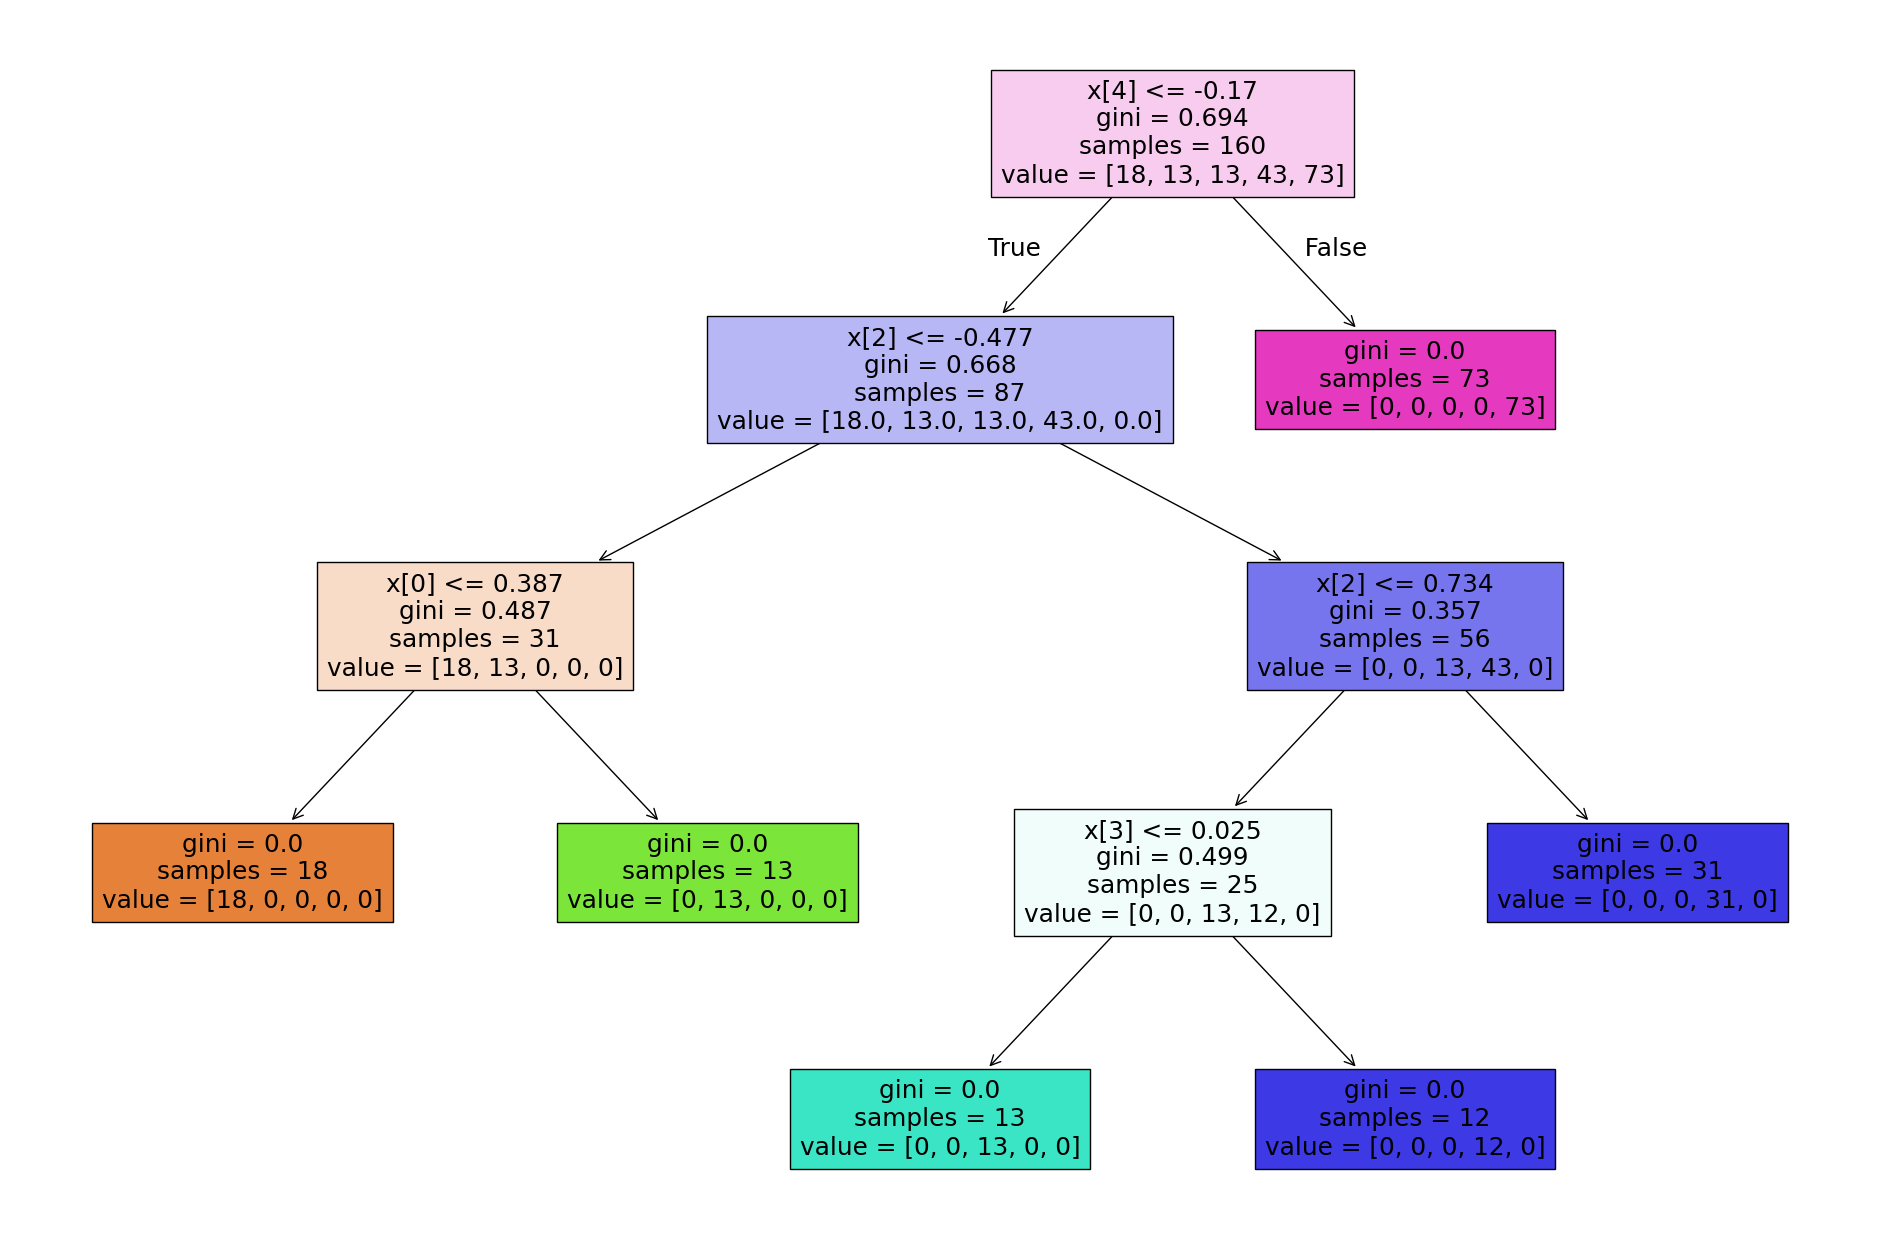

In [50]:
from sklearn import tree

plt.figure(figsize=(24,16))
tree.plot_tree(best_model , filled=True);